<a href="https://colab.research.google.com/github/jjsalaza/Ingenieria-Logistica-ULL/blob/master/logistica.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Técnicas Clásicas de Optimización, curso 2019-2020
---



# Introducción

Principalmente aprendemos a representar problemas reales mediante modelos matemáticos de programación lineal (continua o entera), es decir, del tipo $\max\{ c^Tx: Ax\leq b, x\in Z^n\}$. Luego estos modelos matemáticos serán resueltos mediante herramientas informáticas especializadas, como [Cplex](https://www.ibm.com/analytics/cplex-optimizer), [Xpress](http://www.fico.com/es/products/fico-xpress-optimization), Gurobi, SCIP, GLKP, CBC, GLOP, etc. Aunque dedicamos algo a comprender las metodologías implementadas en estas herramientas, principalmente la asignatura insistirá en la modelización de problemas.


Un ejemplo de modelo matemático es:
\begin{eqnarray}
\max\;\; x+10y& & \\
x+7y&\leq& 17.5  \\
x &\leq& 3.5  \\
x,y&\in& Z
\end{eqnarray}

A fín de no complicarnos con la instalación de licencias comerciales, usamos una librería de optimización de software libre que permite ser llamada desde Python y que ha sideo desarrollada en el proyecto [COIN-OR](https://www.coin-or.org/). Se llama CBC. Además en este mismo proyecto existe un lenguaje que amplía el Python y se llama [PuLP](https://www.coin-or.org/PuLP/). Usando este lenguaje el modelo anterior se resuelve mediante:


In [1]:
!pip install pulp
from pulp import *

In [2]:
prob = LpProblem("MiPrimerProblemaEntero", LpMaximize)
X = LpVariable("X", 0, None,cat='Integer')
Y = LpVariable("Y", 0, None,cat='Integer')
prob += X + 10 * Y
prob += X + 7 * Y <= 17.5
prob += X <= 3.5


In [3]:
prob.solve()

print("Status = ", LpStatus[prob.status])
print("Optimal objective value = ", value(prob.objective))
print("  X = ", X.varValue)
print("  Y = ", Y.varValue)
# prob.writeLP("modelo.lp")
# print(prob)

Status =  Optimal
Optimal objective value =  23.0
  X =  3.0
  Y =  2.0


Pero con el lenguaje PuLP podemos usar otras librerias de optimización.  Por ejemplo podemos usar GLPK o LPSOLVER que son otras librerías gratuitas de optimización, o Gurobi o Cplex o Xpress que son de pago:

In [4]:
from gurobipy import *

prob.solve( GUROBI( TimeLimit=60 , msg=False ) )

print("Status = ", LpStatus[prob.status])
print("Optimal objective value = ", value(prob.objective))
print("  X = ", X.varValue)
print("  Y = ", Y.varValue)

Academic license - for non-commercial use only
Status =  Optimal
Optimal objective value =  23.0
  X =  3.0
  Y =  2.0


In [5]:
!pip install cplex
from cplex import *

prob.solve( CPLEX(msg=False) )

print("Status = ", LpStatus[prob.status])
print("Optimal objective value = ", value(prob.objective))
print("  X = ", X.varValue)
print("  Y = ", Y.varValue)

Status =  Optimal
Optimal objective value =  23.0
  X =  3.0
  Y =  2.0


In [6]:
!pip install xpress
from xpress import *

prob.solve( XPRESS(msg=True, keepFiles=True) )

print("Status = ", LpStatus[prob.status])
print("Optimal objective value = ", value(prob.objective))
print("  X = ", X.varValue)
print("  Y = ", Y.varValue)

Using the Community license in this session. If you have a full Xpress license,
first set the XPRESS environment variable to the directory containing the license file,
xpauth.xpr, and then restart Python. If you want to use the FICO Community license
and no longer want to see this message, set the XPRESS environment variable to
 C:\Anaconda3\lib\site-packages\xpress/license
Status =  Optimal
Optimal objective value =  23.0
  X =  3.0
  Y =  2.0


En este sentido parece un lenguaje **ideal**, pero hay que tener en cuenta que algunas librerías ofrecen funciones no disponibles en otras librerias (por ejemplo, callback functions) con lo que igual tampoco PuLP es tan "ideal".

Otra alternativa es usar la nueva herramienta gratuita (¡por ahora!) de Google llamada [OR-tools](https://developers.google.com/optimization/). Ni PuLP ni OR-tools son librerías de optimización, sino extensiones del lenguaje Python para escribir cómodamente modelos matemáticos de Programación Lineal (Entera o Continua) que luego pueden ser resueltas con cualquiera de las librerias citadas (CBC, Cplex, Gurobi,...). Actúan como puente entre quien desea resolver un modelo y quien lo resuelve. Muy cómodo. Muy recomendable. 

Para usar la herramienta OR-tools de Google:

In [7]:
!pip install ortools
from ortools.linear_solver import pywraplp

Aqui hay 2 motores de optimización. Uno para programación lineal **continua** llamado GLOP_LINEAR_PROGRAMMING que está construido por Google, y otro para programación lineal **entera** llamado CBC_MIXED_INTEGER_PROGRAMMING que está prestado por Coin-OR. Existe la posibilidad de usar otros motores de optimización (terceros), pero para ello hay que instalarse el código fuente de Google OR-tools en tu ordenador local.

In [8]:
solver = pywraplp.Solver('MiPrimerProblemaEntero', pywraplp.Solver.CBC_MIXED_INTEGER_PROGRAMMING)
#solver = pywraplp.Solver('MiPrimerProblemaEntero', pywraplp.Solver.SCIP_MIXED_INTEGER_PROGRAMMING)
#solver = pywraplp.Solver('MiPrimerProblemaEntero', pywraplp.Solver.GLPK_MIXED_INTEGER_PROGRAMMING)
#solver = pywraplp.Solver('MiPrimerProblemaEntero', pywraplp.Solver.CPLEX_MIXED_INTEGER_PROGRAMMING)
#solver = pywraplp.Solver('MiPrimerProblemaEntero', pywraplp.Solver.GUROBI_MIXED_INTEGER_PROGRAMMING)
#solver = pywraplp.Solver('MiPrimerProblemaEntero', pywraplp.Solver.XPRESS_MIXED_INTEGER_PROGRAMMING)
#solver = pywraplp.Solver('MiPrimerProblemaEntero', pywraplp.Solver.GLOP_LINEAR_PROGRAMMING)  # solo continua
#solver = pywraplp.Solver('MiPrimerProblemaEntero', pywraplp.Solver.BOP_INTEGER_PROGRAMMING)  # solo 0-1

x = solver.IntVar(0.0, solver.infinity(), 'x')
y = solver.IntVar(0.0, solver.infinity(), 'y')

solver.Maximize(x + 10 * y)
solver.Add( x + 7 * y <= 17.5 )
solver.Add( x <= 7.5 )  

result_status = solver.Solve()
assert result_status == pywraplp.Solver.OPTIMAL
  
print('Number of variables =', solver.NumVariables())
print('Number of constraints =', solver.NumConstraints())
print('Optimal objective value = %d' % solver.Objective().Value())
  
variable_list = [x, y]
for variable in variable_list:
    print('   %s = %d' % (variable.name(), variable.solution_value()))

Number of variables = 2
Number of constraints = 2
Optimal objective value = 23
   x = 3
   y = 2


Tenemos en OR-tools dos modos de escribir los detalles del modelo: o bien coeficiente a coeficiente, o bien fila a fila. Arriba hemos usado el fila-a-file y a abajo verás el columna-a-columna.

In [9]:
solver = pywraplp.Solver('MiPrimerProblemaEntero', pywraplp.Solver.CBC_MIXED_INTEGER_PROGRAMMING)

# x and y are integer non-negative variables.
x = solver.IntVar(0.0, solver.infinity(), 'x')
y = solver.IntVar(0.0, solver.infinity(), 'y')

# x + 7 * y <= 17.5
constraint1 = solver.Constraint(-solver.infinity(), 17.5)
constraint1.SetCoefficient(x, 1)
constraint1.SetCoefficient(y, 7)

# x <= 3.5
constraint2 = solver.Constraint(-solver.infinity(), 3.5)
constraint2.SetCoefficient(x, 1)
constraint2.SetCoefficient(y, 0)

# Maximize x + 10 * y.
objective = solver.Objective()
objective.SetCoefficient(x, 1)
objective.SetCoefficient(y, 10)
objective.SetMaximization()

"""Solve the problem and print the solution."""
result_status = solver.Solve()
# The problem has an optimal solution.
assert result_status == pywraplp.Solver.OPTIMAL
  
print('Number of variables =', solver.NumVariables())
print('Number of constraints =', solver.NumConstraints())
print('Optimal objective value = %d' % solver.Objective().Value())
  
# The value of each variable in the solution.
variable_list = [x, y]
for variable in variable_list:
    print('   %s = %d' % (variable.name(), variable.solution_value()))

Number of variables = 2
Number of constraints = 2
Optimal objective value = 23
   x = 3
   y = 2


Personalmente creo que el modo "fila a fila" es más claro. Pero pueden haber usuarios que prefieran el "columna a columna" (que fue el formato original de las primeras herramientas informáticas en Programación Matemática).

El anterior ejemplo fue un modelo ejemplo muy pequeño, con tan sólo 2 variables y 2 restricciones. Es un ejemplo numérico diminuto, de nulo interés práctico. En la práctica se plantean problemas más complejos que necesitan ser representado mediante modelos con más variables y restricciones, y en consecuencia donde notación abreviada ayuda a entenderlos mejor y reducir la posibilidad de cometer errores al introducirlos en un ordenador. Veamos un ejemplo de problema mayor en la siguiente sección.

Pero incluso los modelos de programación entera pequeños pueden ser muy difíciles. Aqui lo mostramos con uno con 3 variables:

In [10]:
solver = pywraplp.Solver('ProblemaEnteroDificil',  pywraplp.Solver.CBC_MIXED_INTEGER_PROGRAMMING )

x = solver.IntVar(0.0, solver.infinity(), 'x')
y = solver.IntVar(0.0, solver.infinity(), 'y')
z = solver.IntVar(0.0, solver.infinity(), 'z')

solver.SetTimeLimit( 60 * 1000 )   # le ponemos un tiempo límite de 60 segundos para no calentar el ordenador

solver.Minimize(x)
solver.Add( 75001 * y + 75002 * z == 75000 + 75000 * x )
result_status = solver.Solve()

if result_status == pywraplp.Solver.OPTIMAL:
  
    print('Number of variables =', solver.NumVariables())
    print('Number of constraints =', solver.NumConstraints())
    print('Optimal objective value = %d' % solver.Objective().Value())
  
    variable_list = [x, y, z]
    for variable in variable_list:
         print('   %s = %d' % (variable.name(), variable.solution_value()))
else:
    print(' Finalizó sin optimo : status = ',result_status)
    
print("Time = ", solver.WallTime(), " milliseconds")
print("Iterations = ", solver.Iterations())
print("Nodes = ", solver.nodes())

 Finalizó sin optimo : status =  2
Time =  51749  milliseconds
Iterations =  1505106
Nodes =  2254555


Mismo problema con Gurobi, aunque no te funcionará si no tienes la licencia apropiada en el ordenador donde lo quieras resolver:

In [11]:
from gurobipy import *

modelo = Model("ProblemaEnteroDificil")

x = modelo.addVar(vtype=GRB.INTEGER, name="x")
y = modelo.addVar(vtype=GRB.INTEGER, name="y")
z = modelo.addVar(vtype=GRB.INTEGER, name="z")

modelo.setObjective(x, GRB.MINIMIZE)
modelo.addConstr( 75001 * y + 75002 * z == 75000 + 75000 * x , "c0")
modelo.optimize()

print('Optimal  objective value = %g' % modelo.objVal)
for variable in modelo.getVars():
    print('  %s = %g' % (variable.varName, variable.x))
print('runtime is ',modelo.Runtime)

Optimal  objective value = 37500
  x = 37500
  y = 0
  z = 37500
runtime is  0.0039882659912109375


Si comparas los tiempos de cálculo de esas dos herramientas entenderás mejor la diferencia entre "gratis" (CBC) y "de pago" (Gurobi)!!!

Comencemos ahora con problemas más serios, de más utilidad.

# Problemas de Asignación

Imaginemos tener 6 trabajadores y 4 tareas, y conocer el costo de $c_{ij}$ de que el trabajador $i$ esté asignado a la tarea $j$. Se busca asignar un trabajador a cada tarea, y que ningún trabajador esté asignado a más de una máquina, de manera que el coste total sea lo menor posible.


In [1]:
cost  =  [[ 90,  76,  75,  70],
          [ 35,  85,  55,  65],
          [125,  95,  90, 105],
          [ 45, 110,  95, 115],
          [ 60, 105,  80,  75],
          [ 45,  65, 110,  95]]
workers = range( len(cost) )
tasks   = range( len(cost[1]) )
EPS     = 0.0001

In [2]:
!pip install ortools
from ortools.linear_solver import pywraplp

solver = pywraplp.Solver('ProblemaAsignacion2dimensional', pywraplp.Solver.CBC_MIXED_INTEGER_PROGRAMMING)

x = {}
for i in workers:
    for j in tasks:
        x[i,j] = solver.BoolVar('x[%i,%i]' % (i,j) )

solver.Minimize(solver.Sum(cost[i][j] * x[i,j] for i in workers for j in tasks))

for i in workers:
    solver.Add(solver.Sum(x[i,j] for j in tasks) <= 1)

for j in tasks:
    solver.Add(solver.Sum(x[i,j] for i in workers) == 1)

solver.Solve()

print('Costo total = ', solver.Objective().Value())
print()
for i in workers:
    for j in tasks:
        if x[i, j].solution_value() > EPS :
            print('Trabajador %d asignado a la tarea %d.  Costo = %d' % (i,j,cost[i][j]))
print()
print("Time = ", solver.WallTime()/1000, "seconds")

Costo total =  235.0

Trabajador 0 asignado a la tarea 3.  Costo = 70
Trabajador 1 asignado a la tarea 2.  Costo = 55
Trabajador 3 asignado a la tarea 0.  Costo = 45
Trabajador 5 asignado a la tarea 1.  Costo = 65

Time =  0.006 seconds


Si los trabajadores estuviesen en dos equipos (por ejemplo, pares e impares) la solución óptima obtenida usa más trabajadores de un equipo que del otro. Podría tener sentido que el problema real también desee una solución donde se elijan exactamente 2 trabajadores de cada equipo. Para ello hay que introducir nuevas restricciones en el modelo matemático:

In [3]:
team1 = [0, 2, 4]
team2 = [1, 3, 5]

solver.Add(solver.Sum(x[i, j] for i in team1 for j in tasks) <= 2)
solver.Add(solver.Sum(x[i, j] for i in team2 for j in tasks) <= 2)

solver.Solve()

print('Costo total = ', solver.Objective().Value())
for i in workers:
    for j in tasks:
        if x[i, j].solution_value() > 0:
            print('Trabajador %d asignado a la tarea %d.  Costo = %d' % (i,j,cost[i][j]))

Costo total =  250.0
Trabajador 0 asignado a la tarea 2.  Costo = 75
Trabajador 1 asignado a la tarea 0.  Costo = 35
Trabajador 4 asignado a la tarea 3.  Costo = 75
Trabajador 5 asignado a la tarea 1.  Costo = 65


Como era de esperar, la nueva solución óptima cuesta más que la anterior porque debe cumplir además las nuevas desigualdades.

Terminemos esta sección con un problema de asignación más complejo, conocido como **problema de asignación 3-dimensional**. Pensemos ahora que tenemos 5 profesores, 5 asignaturas y 5 aulas, y queremos asignar un profesor a cada asignatura en un aula, de modo que cada profesor da 1 asignatura en 1 aula, cada asignatura la da 1 profesor en 1 aula, y cada aula imparte 1 asignatura por 1 profesor. Todo queremos que se realice a costo total mínimo. Concretamente se llama problema de asignación 3-dimensional **axial** porque como veremos su modelo matemático se basa en restricciones que tienen 1 índice libre, en contraposición a otro problema que se llama de asignación 3-dimensional **planar** donde su modelo se basa en restricciones que tienen 2 indices libres. Vemos primero el modelo para el problema axial planteado, es decir, asignar profesores, asignaturas y aulas:

In [4]:
import random  
dimension = 10
opciones  = range(dimension)
random.seed(12345)
cost      = [[[random.randint(1,100) for i in opciones] for j in opciones] for k in opciones]
EPS       = 0.001

In [5]:
solver = pywraplp.Solver('3APaxial', pywraplp.Solver.CBC_MIXED_INTEGER_PROGRAMMING)
x = {}
for i in opciones:
    for j in opciones:
        for k in opciones:
            x[i,j,k] = solver.BoolVar('x[%i,%i,%i]' % (i,j,k))

# Objective
solver.Minimize( solver.Sum(cost[i][j][k] * x[i,j,k] for i in opciones for j in opciones for k in opciones))

# Constraints

[ solver.Add(solver.Sum(x[i,j,k] for j in opciones for k in opciones) == 1) for i in opciones ]
[ solver.Add(solver.Sum(x[i,j,k] for i in opciones for k in opciones) == 1) for j in opciones ]
[ solver.Add(solver.Sum(x[i,j,k] for i in opciones for j in opciones) == 1) for k in opciones ]
    
# resolvemos:  
sol = solver.Solve()

print('Costo total = ', solver.Objective().Value())
print()
for i in opciones:
    for j in opciones:
        for k in opciones:
            if x[i,j,k].solution_value() > EPS :
                print('Prof %d con asignatura %d en aula %d.  Costo = %d' % (i,j,k,cost[i][j][k]))
print()
print("Time = ", solver.WallTime(), " milliseconds")

Costo total =  29.0

Prof 0 con asignatura 9 en aula 4.  Costo = 2
Prof 1 con asignatura 4 en aula 6.  Costo = 1
Prof 2 con asignatura 8 en aula 2.  Costo = 6
Prof 3 con asignatura 5 en aula 1.  Costo = 7
Prof 4 con asignatura 6 en aula 9.  Costo = 1
Prof 5 con asignatura 3 en aula 0.  Costo = 1
Prof 6 con asignatura 0 en aula 8.  Costo = 1
Prof 7 con asignatura 7 en aula 7.  Costo = 1
Prof 8 con asignatura 2 en aula 5.  Costo = 2
Prof 9 con asignatura 1 en aula 3.  Costo = 7

Time =  214  milliseconds


El modelo del problema de asignación 3-dimensional **planar** es el siguiente. Nótese que **no** es un modelo alternativo para el problema de asignación de profesores, asignatura y aulas. Es el modelo de otro problema diferente. Por eso la solución óptima del modelo anterior y del modelo siguiente no coinciden, ni tienen relación alguna. Si tienes curiosidad por conocer el problema asociado a este otro modelo, te sugiero que estudies el concepto de [Cuadrado Latino](https://es.wikipedia.org/wiki/Cuadrado_latino).

In [6]:
solver = pywraplp.Solver('3APplanar', pywraplp.Solver.CBC_MIXED_INTEGER_PROGRAMMING)
x = {}
for i in opciones:
    for j in opciones:
        for k in opciones:
            x[i,j,k] = solver.BoolVar('x[%i,%i,%i]' % (i,j,k))

solver.Minimize( solver.Sum(cost[i][j][k] * x[i,j,k] for i in opciones for j in opciones for k in opciones) )

[ solver.Add(solver.Sum(x[i,j,k] for k in opciones) == 1) for i in opciones for j in opciones ]
[ solver.Add(solver.Sum(x[i,j,k] for j in opciones) == 1) for i in opciones for k in opciones ]
[ solver.Add(solver.Sum(x[i,j,k] for i in opciones) == 1) for j in opciones for k in opciones ]
    
solver.Solve()

print('Costo total = ', solver.Objective().Value())
print()
for i in opciones:
    for j in opciones:
        for k in opciones:
            if x[i,j,k].solution_value() > EPS :
                print('Indices: %d  %d  %d.  Costo = %d' % (i,j,k,cost[i][j][k]))
print()
print("Time = ", solver.WallTime()/1000, " seconds")

Costo total =  1813.0

Indices: 0  0  4.  Costo = 48
Indices: 0  1  2.  Costo = 56
Indices: 0  2  3.  Costo = 12
Indices: 0  3  7.  Costo = 4
Indices: 0  4  0.  Costo = 4
Indices: 0  5  6.  Costo = 14
Indices: 0  6  8.  Costo = 30
Indices: 0  7  1.  Costo = 28
Indices: 0  8  5.  Costo = 2
Indices: 0  9  9.  Costo = 11
Indices: 1  0  2.  Costo = 2
Indices: 1  1  4.  Costo = 2
Indices: 1  2  7.  Costo = 16
Indices: 1  3  0.  Costo = 11
Indices: 1  4  6.  Costo = 1
Indices: 1  5  1.  Costo = 13
Indices: 1  6  3.  Costo = 4
Indices: 1  7  9.  Costo = 16
Indices: 1  8  8.  Costo = 26
Indices: 1  9  5.  Costo = 38
Indices: 2  0  3.  Costo = 34
Indices: 2  1  9.  Costo = 5
Indices: 2  2  0.  Costo = 36
Indices: 2  3  4.  Costo = 7
Indices: 2  4  1.  Costo = 1
Indices: 2  5  5.  Costo = 39
Indices: 2  6  7.  Costo = 11
Indices: 2  7  6.  Costo = 15
Indices: 2  8  2.  Costo = 6
Indices: 2  9  8.  Costo = 13
Indices: 3  0  6.  Costo = 2
Indices: 3  1  5.  Costo = 21
Indices: 3  2  9.  Costo = 3


Hasta ahora hemos estado usando el software gratuito CBC a través de la herramienta OR-tools de Google. Para resolverlo con Gurobi (recuerda que necesitas licencia sobre el ordenador en el que lo quieres resolver) la sintaxis es:

In [7]:
from gurobipy import *

modelo = Model("AP3axial")
x = {}
for i in opciones:
    for j in opciones:
        for k in opciones:
            x[i,j,k] = modelo.addVar(vtype=GRB.BINARY, name="x[%i,%i,%i]" % (i,j,k))

modelo.modelSense = GRB.MINIMIZE
modelo.setObjective( quicksum(cost[i][j][k] * x[i,j,k] for i in opciones for j in opciones for k in opciones) )
    
[ modelo.addConstr( quicksum(x[i,j,k] for j in opciones for k in opciones) == 1 ) for i in opciones ]
[ modelo.addConstr( quicksum(x[i,j,k] for i in opciones for k in opciones) == 1 ) for j in opciones ]
[ modelo.addConstr( quicksum(x[i,j,k] for i in opciones for j in opciones) == 1 ) for k in opciones ]
                    
modelo.optimize()
                    
print('Costo total = %g' % modelo.objVal)
print()
for i in opciones:
    for j in opciones:
        for k in opciones:
            if x[i,j,k].x > EPS:
                print('Indices: %d  %d  %d.  Costo = %d' % (i,j,k,cost[i][j][k]))
print()
print('Time = ',modelo.Runtime, " seconds")

Academic license - for non-commercial use only
Optimize a model with 30 rows, 1000 columns and 3000 nonzeros
Variable types: 0 continuous, 1000 integer (1000 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective 445.0000000
Presolve time: 0.01s
Presolved: 30 rows, 1000 columns, 3000 nonzeros
Variable types: 0 continuous, 1000 integer (1000 binary)

Root relaxation: objective 2.120000e+01, 49 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0   21.20000    0   22  445.00000   21.20000  95.2%     -    0s
H    0     0                      41.0000000   21.20000  48.3%     -    0s
     0     0   23.14286    0   28   41.00000   23.14286  43.6%     -    0s
     0     0   23.14286    0   22   41.00000   23.142

In [8]:
from gurobipy import *

modelo = Model("AP3planar")
x = {}
for i in opciones:
    for j in opciones:
        for k in opciones:
            x[i,j,k] = modelo.addVar(vtype=GRB.BINARY, name="x[%i,%i,%i]" % (i,j,k))

modelo.modelSense = GRB.MINIMIZE
modelo.setObjective( quicksum(cost[i][j][k] * x[i,j,k] for i in opciones for j in opciones for k in opciones) )
    
[ modelo.addConstr( quicksum(x[i,j,k] for k in opciones) == 1 ) for i in opciones for j in opciones ]
[ modelo.addConstr( quicksum(x[i,j,k] for j in opciones) == 1 ) for i in opciones for k in opciones ]
[ modelo.addConstr( quicksum(x[i,j,k] for i in opciones) == 1 ) for j in opciones for k in opciones ]
                    
modelo.optimize()
                    
print('Costo total = %g' % modelo.objVal)
print()
for i in opciones:
    for j in opciones:
        for k in opciones:
            if x[i,j,k].x > EPS:
                print('Indices: %d  %d  %d.  Costo = %d' % (i,j,k,cost[i][j][k]))
print()
print('Time = ',modelo.Runtime, " seconds")

Optimize a model with 300 rows, 1000 columns and 3000 nonzeros
Variable types: 0 continuous, 1000 integer (1000 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Presolve time: 0.01s
Presolved: 300 rows, 1000 columns, 3000 nonzeros
Variable types: 0 continuous, 1000 integer (1000 binary)

Root relaxation: objective 1.761849e+03, 453 iterations, 0.01 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 1761.84861    0  237          - 1761.84861      -     -    0s
H    0     0                    4638.0000000 1761.84861  62.0%     -    0s
H    0     0                    3051.0000000 1761.84861  42.3%     -    0s
     0     0 1765.28503    0  244 3051.00000 1765.28503  42.1%     -    0s
     0     0 1765.54162    0  243 3051.00000 1765.54162  42.1%     -  

# Problemas de Caminos

Resolvamos el problema de calcular el camino de costo mínimo del nodo $s=0$ al nodo $t=n-1$ en un grafo dirigido con costos positivos:

In [9]:
n        = 100
opciones = range(n)
s = 0    # source
t = n-1  # target

import random
random.seed(1)
points   = [(random.randint(0,100),random.randint(0,100)) for i in opciones]

import matplotlib.pyplot as plt
def dibuja(selected):
    plt.plot([p[0] for p in points], [p[1] for p in points], 'bo')
    for (i,j) in selected:
        plt.plot([points[i][0],points[j][0]], [points[i][1],points[j][1]], 'g-')
    plt.plot(points[s][0],points[s][1], 'rs')
    plt.plot(points[t][0],points[t][1], 'rs')

dibuja({})

import math
def distance(points, i, j):
    dx = points[i][0] - points[j][0]
    dy = points[i][1] - points[j][1]
    return math.floor(math.sqrt(dx*dx + dy*dy))
        
!pip install ortools
from ortools.linear_solver import pywraplp

Costo total =  43.0
Time =  0.478 seconds
Optimal path: [(0, 52), (52, 99)]


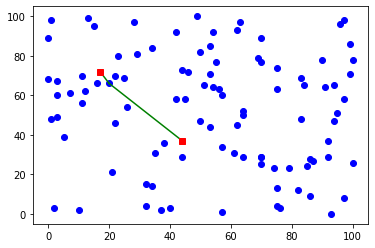

In [10]:
solver = pywraplp.Solver('ShortestPath', pywraplp.Solver.CBC_MIXED_INTEGER_PROGRAMMING)

x = {}
for i in opciones:
    for j in opciones:
        x[i,j] = solver.BoolVar('x[%i,%i]' % (i,j))
y = {}
for i in opciones:
    y[i] = solver.BoolVar('y[%i]' % i)
            
solver.Minimize( solver.Sum(distance(points,i,j) * x[i,j] for i in opciones for j in opciones if i!=j ) )

solver.Add(solver.Sum(x[s,j] for j in opciones if j!=s ) == 1)
solver.Add(solver.Sum(x[i,s] for i in opciones if i!=s ) == 0)
solver.Add(solver.Sum(x[i,t] for i in opciones if i!=t ) == 1)
solver.Add(solver.Sum(x[t,j] for j in opciones if j!=t ) == 0)
[ solver.Add(solver.Sum(x[i,j] for j in opciones if j!=i) == y[i]) for i in opciones if i!=s and i!=t ]
[ solver.Add(solver.Sum(x[i,j] for i in opciones if j!=i) == y[j]) for j in opciones if j!=s and j!=t ]
    
solver.Solve()

print('Costo total = ', solver.Objective().Value())
print("Time = ", solver.WallTime()/1000, "seconds")    

selected = [(i,j) for i in opciones for j in opciones if x[i,j].solution_value() > 0.5]
print('Optimal path: %s' % str(selected))

dibuja(selected)

Para que el anterior modelo funcione es fundamental que no existan circuitos de costo negativo o nulo, cosa que viene garantizada si las distancias son positivas.

# Problema del Viajante de Comercio

El Problema del Viajante de Comercio ("Travelling Salesman Problem") busca un circuito que visite una vez cada uno de los nodos de un grafo, con el menos coste posible de recorrido del circuito. Comenzamos generando datos aleatorios. Primero lo haremos sin ninguna propiedad de la matriz de costos, mostrando 10 modelos diferentes,  y más adelante lo haremos con puntos sobre un espacio cartesiano y distancias euclídeas, mostrando 4 variantes del mejor modelo. El ejercicio es importante porque muestra que pueden existir varios modelos para un mismo problema, y que no todos los modelos de un problema requieren el mismo tiempo de cálculo para ser resueltos. De este ejercicio sobre el TSP aprenderemos a reconocer modelos buenos y modelos malos. Comencemos generando $n$ puntos y distancias aleatorias entre ellos (es decir, un grafo asimétrico con $n$ nodos), es decir, un ejemplo numérico para el ATSP.

In [2]:
import random
n     = 30
todos = range(n)
otros = range(1,n)
random.seed(12345)
dist  = { (i,j) : random.randint(1,100) for i in todos for j in todos if i!=j }
EPS   = 0.001

Usando OR-tools como marco de trabajo, y CBC como librería de optimización lineal entera, mostramos primero 3 modelos para el ATSP:

In [1]:
!pip install ortools
from ortools.linear_solver import pywraplp

In [9]:
def ATSPx(tipo):
    if tipo == 'LP':
        print("lineal ")
        solver = pywraplp.Solver('ATSPx', pywraplp.Solver.GLOP_LINEAR_PROGRAMMING)
    else:
        print("entero ")
        solver = pywraplp.Solver('ATSPx', pywraplp.Solver.CBC_MIXED_INTEGER_PROGRAMMING)
    x = {}
    for i,j in dist.keys():
        for k in todos:
            if tipo == 'LP':
                x[i,j,k] = solver.NumVar(0.0, solver.infinity(), 'x[%i,%i,%i]' % (i,j,k))
            else:
                x[i,j,k] = solver.BoolVar('x[%i,%i,%i]' % (i,j,k))
            

    solver.Minimize( solver.Sum( dist[i,j]*x[i,j,k] for i,j in dist.keys() for k in todos ))
    
    [ solver.Add( solver.Sum(x[i,j,k]   for k in todos for j in todos if j!=i) == 1  )  for i in todos ]
    [ solver.Add( solver.Sum(x[i,j,k]   for k in todos for i in todos if j!=i) == 1  )  for j in todos ]
    [ solver.Add( solver.Sum(x[i,j,k]   for i,j in dist.keys() ) == 1  )  for k in todos ]
    solver.Add(   solver.Sum(x[0,j,0]   for j in otros ) == 1 )
    solver.Add(   solver.Sum(x[j,0,n-1] for j in otros ) == 1 )
    [ solver.Add( solver.Sum(x[j,i,k-1] for j in todos if j!=i) == solver.Sum(x[i,j,k] for j in todos if j!=i))  for i in otros for k in otros ]
        
    solver.Solve()
    print('Distancia total con variable x3i = ', solver.Objective().Value(),'kilometros en ', solver.WallTime(), " milliseconds")

def ATSPu(tipo):
    if tipo == 'LP':
        solver = pywraplp.Solver('ATSPu', pywraplp.Solver.GLOP_LINEAR_PROGRAMMING)
    else:
        solver = pywraplp.Solver('ATSPu', pywraplp.Solver.CBC_MIXED_INTEGER_PROGRAMMING)
    x = {}
    for i,j in dist.keys():
        if tipo == 'LP':
            x[i,j] = solver.NumVar(0.0, solver.infinity(), 'x[%i,%i]' % (i,j))
        else:
            x[i,j] = solver.BoolVar('x[%i,%i]' % (i,j))
    u = {}
    for i in otros:
        u[i] = solver.NumVar(0.0, solver.infinity(), 'u[%i]' % i)  

    solver.Minimize( solver.Sum( dist[i,j]*x[i,j] for i,j in dist.keys() ))
    
    [ solver.Add( solver.Sum(x[i,j] for j in todos if i!=j) == 1  )  for i in todos ]
    [ solver.Add( solver.Sum(x[j,i] for j in todos if i!=j) == 1  )  for i in todos ]
    [ solver.Add( u[j] >= u[i] + x[i,j] - (n-2)*(1-x[i,j]) + (n-3)*x[j,i]   ) for i in otros for j in otros if j!=i ]
        
    solver.Solve()
    print('Distancia total con variable ui  = ', solver.Objective().Value(),'kilometros en ', solver.WallTime(), " milliseconds")

def ATSPvij(tipo):
    if tipo == 'LP':
        solver = pywraplp.Solver('ATSPvij', pywraplp.Solver.GLOP_LINEAR_PROGRAMMING)
    else:
        solver = pywraplp.Solver('ATSPvij', pywraplp.Solver.CBC_MIXED_INTEGER_PROGRAMMING)
    x = {}
    for i,j in dist.keys():
        if tipo == 'LP':
            x[i,j] = solver.NumVar(0, solver.infinity(), 'x[%i,%i]' % (i,j))
        else:
            x[i,j] = solver.BoolVar('x[%i,%i]' % (i,j))
    v = {}
    for i in otros: 
        for j in otros: 
            if j!=i :
                v[i,j] = solver.NumVar(0, solver.infinity(), 'v[%i,%i]' % (i,j))            
    
    solver.Minimize( solver.Sum( dist[i,j]*x[i,j] for i,j in dist.keys() ))
    
    [ solver.Add( solver.Sum(x[i,j] for j in todos if i!=j) == 1  )  for i in todos ]
    [ solver.Add( solver.Sum(x[j,i] for j in todos if i!=j) == 1  )  for i in todos ]
    [ solver.Add( v[i,j] + v[j,i] == 1 )        for i in otros for j in otros if j!=i ]
    [ solver.Add( v[i,j] + v[j,k] <= v[i,k]+1 ) for i in otros for j in otros for k in otros if i!=j and i!=k and j!=k ]
    [ solver.Add( v[i,j] >= x[i,j]  )           for i in otros for j in otros if j!=i ]
    
    solver.Solve()
    print('Distancia total con variable vij = ', solver.Objective().Value(),'kilometros en ', solver.WallTime(), " milliseconds")

def ATSPfij(tipo):
    if tipo == 'LP':
        solver = pywraplp.Solver('ATSPfij', pywraplp.Solver.GLOP_LINEAR_PROGRAMMING)
    else:
        solver = pywraplp.Solver('ATSPfij', pywraplp.Solver.CBC_MIXED_INTEGER_PROGRAMMING)
    x = {}
    for i,j in dist.keys():
        if tipo == 'LP':
            x[i,j] = solver.NumVar(0.0, solver.infinity(), 'x[%i,%i]' % (i,j))
        else:
            x[i,j] = solver.BoolVar('x[%i,%i]' % (i,j))
    f = {}
    for i,j in dist.keys():
        f[i,j] = solver.NumVar(0.0, solver.infinity(), 'f[%i,%i]' % (i,j))         
                
    solver.Minimize(solver.Sum( dist[i,j]*x[i,j] for i,j in dist.keys() ))
    
    [ solver.Add( solver.Sum(       x[i,j] for j in todos if i!=j) == 1 )  for i in todos ]
    [ solver.Add( solver.Sum(       x[j,i] for j in todos if i!=j) == 1 )  for i in todos ]
    [ solver.Add( solver.Sum(f[j,i]-f[i,j] for j in todos if j!=i) >= 1 )  for i in otros ] 
    [ solver.Add(            f[i,j] <= (n-1)*x[i,j]           )    for i,j in dist.keys() ]
    
    solver.Solve()
    print('Distancia total con variable fij = ', solver.Objective().Value(),'kilometros en ', solver.WallTime(), " milliseconds")

ATSPx('LP')
ATSPu('LP')
ATSPvij('LP')
ATSPfij('LP')

ATSPx("ip")
ATSPu("ip")
ATSPvij("ip")
ATSPfij("ip")

lineal 
Distancia total con variable x3i =  150.80000000000035 kilometros en  1784  milliseconds
Distancia total con variable ui  =  149.6896551724138 kilometros en  53  milliseconds
Distancia total con variable vij =  154.25 kilometros en  1014  milliseconds
Distancia total con variable fij =  150.48275862068965 kilometros en  52  milliseconds
entero 
Distancia total con variable x3i =  155.0 kilometros en  44978  milliseconds
Distancia total con variable ui  =  155.0 kilometros en  1351  milliseconds
Distancia total con variable vij =  155.0 kilometros en  20384  milliseconds
Distancia total con variable fij =  155.0 kilometros en  511  milliseconds


Cambiemos ahora el resolutor. En lugar de usar el gratuito OR-tools usemos el comercial Gurobi (recuerda que necesitas licencia de Gurobi para que funcione):

In [1]:
import networkx
from gurobipy import *

In [14]:
def ATSPpot():
    modelo = Model()
    
    x = tupledict()
    for i,j in dist.keys():
         x[i,j] = modelo.addVar(obj=dist[i,j], vtype=GRB.BINARY, name='a[%d,%d]'%(i,j))
    u = tupledict()
    for i in otros:
        u[i] = modelo.addVar(obj=0, vtype=GRB.CONTINUOUS, name='u[%i]'%i)
        
    modelo.addConstrs(sum(x[i,j] for j in todos if j!=i) == 1 for i in todos)
    modelo.addConstrs(sum(x[j,i] for j in todos if j!=i) == 1 for i in todos)
#    modelo.addConstrs( u[j] >= u[i] + x[i,j] - (n+8)*(1-x[i,j]) for i in otros for j in otros if i!=j )
    modelo.addConstrs( u[j] >= u[i] + x[i,j] - (n-2)*(1-x[i,j]) + (n-3)*x[j,i] for i in otros for j in otros if i!=j )

    modelo.optimize()

    print('Costo total = %g' % modelo.objVal)
    print('Time = ',modelo.Runtime, "seconds")
    vals = modelo.getAttr('x', x )
    selected = [(i,j) for i,j in vals.keys() if vals[i,j] > EPS]
    print('Optimal path: %s' % str(selected))
    
ATSPpot()

Optimize a model with 382 rows, 399 columns and 2128 nonzeros
Variable types: 19 continuous, 380 integer (380 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+01]
  Objective range  [1e+00, 1e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+01]
Presolve time: 0.01s
Presolved: 382 rows, 399 columns, 2128 nonzeros
Variable types: 19 continuous, 380 integer (380 binary)

Root relaxation: objective 1.420000e+02, 68 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0     142.0000000  142.00000  0.00%     -    0s

Explored 0 nodes (68 simplex iterations) in 0.02 seconds
Thread count was 4 (of 4 available processors)

Solution count 1: 142 

Optimal solution found (tolerance 1.00e-04)
Best objective 1.420000000000e+02, best bound 1.420000000000e+02, gap 0.0000%
Costo total = 142
Time =  0.026929855346679688 s

In [15]:
def ATSPpred():
    modelo = Model()
    
    x = tupledict()
    for i,j in dist.keys():
         x[i,j] = modelo.addVar(obj=dist[i,j], vtype=GRB.BINARY, name='a[%d,%d]'%(i,j))
    v = tupledict()
    for i,j in dist.keys():
         v[i,j] = modelo.addVar(obj=0        , vtype=GRB.BINARY, name='v[%d,%d]'%(i,j))
        
    modelo.addConstrs(sum(x[i,j] for j in todos if j!=i) == 1 for i in todos)
    modelo.addConstrs(sum(x[j,i] for j in todos if j!=i) == 1 for i in todos)
    modelo.addConstrs( v[i,j]+v[j,i] ==1 for i in otros for j in otros if i!=j )
    modelo.addConstrs( v[i,j]+v[j,k] <= v[i,k]+1 for i in otros for j in otros for k in otros if i!=j and i!=k and j!=k )
    modelo.addConstrs( v[i,j] >= x[i,j] for i in otros for j in otros if i!=j )

    modelo.optimize()

    print('Costo total = %g' % modelo.objVal)
    print('Time = ',modelo.Runtime, "seconds")
    vals = modelo.getAttr('x', x )
    selected = [(i,j) for i,j in vals.keys() if vals[i,j] > EPS]
    print('Optimal path: %s' % str(selected))
    
ATSPpred()

Optimize a model with 6538 rows, 760 columns and 19570 nonzeros
Variable types: 0 continuous, 760 integer (760 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Presolve removed 4218 rows and 209 columns
Presolve time: 0.03s
Presolved: 2320 rows, 551 columns, 7258 nonzeros
Variable types: 0 continuous, 551 integer (551 binary)
Found heuristic solution: objective 852.0000000
Found heuristic solution: objective 847.0000000
Found heuristic solution: objective 742.0000000

Root relaxation: objective 1.420000e+02, 236 iterations, 0.01 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0     142.0000000  142.00000  0.00%     -    0s

Explored 0 nodes (236 simplex iterations) in 0.07 seconds
Thread count was 4 (of 4 available processors)

Solu

Mostremos ahora un cuarto modelo. Este nuevo modelo se basa en variables con 3 índices inspiradas por el problema de asignación 3-dimensional axial, y fue propuesto por Vajda (1961):

In [16]:
def ATSP3ap():
    modelo = Model()
    
    x = tupledict()
    for i in todos:
        for j in todos:
            if i!=j:
                for k in todos:
                    x[i,j,k] = modelo.addVar(obj=dist[i,j], vtype=GRB.BINARY, name='z[%d,%d,%d]'%(i,j,k))
        
    modelo.addConstrs(sum(x[i,j,k] for k in todos for j in todos if j!=i) == 1 for i in todos)
    modelo.addConstrs(sum(x[i,j,k] for k in todos for i in todos if j!=i) == 1 for j in todos)
    modelo.addConstrs(sum(x[i,j,k] for i in todos for j in todos if j!=i) == 1 for k in todos)
    modelo.addConstr (sum(x[0,j,0] for j in otros)==1)
    modelo.addConstr (sum(x[j,0,n-1] for j in otros)==1)
    modelo.addConstrs(sum(x[j,i,k-1] for j in todos if j!=i) == sum(x[i,j,k] for j in todos if j!=i) for i in otros for k in otros)
    modelo.optimize()

    print('Costo total = %g' % modelo.objVal)
    print('Time = ',modelo.Runtime, "seconds")
    vals = modelo.getAttr('x', x )
    selected = [(i,j) for i,j,k in vals.keys() if vals[i,j,k] > EPS]
    print('Optimal path: %s' % str(selected))
    
ATSP3ap()

Optimize a model with 423 rows, 7600 columns and 36556 nonzeros
Variable types: 0 continuous, 7600 integer (7600 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Presolve removed 4 rows and 1406 columns
Presolve time: 0.06s
Presolved: 419 rows, 6194 columns, 30894 nonzeros
Variable types: 0 continuous, 6194 integer (6194 binary)
Found heuristic solution: objective 1249.0000000
Found heuristic solution: objective 883.0000000

Root relaxation: objective 1.420000e+02, 424 iterations, 0.03 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0     142.0000000  142.00000  0.00%     -    0s

Explored 0 nodes (424 simplex iterations) in 0.12 seconds
Thread count was 4 (of 4 available processors)

Solution count 3: 142 883 1249 

Optimal solutio

El modelo anterior hace uso de las ecuaciones:
$$ \sum_{j} x^{k-1}_{ji} = \sum_{j} x^k_{ij} \qquad \forall i,k $$
Otra variante de Fox, Gavish y Graves (1980) consiste en usar las siguientes ecuaciones agregadas:
$$ \sum_{k,j} k x^k_{ij} = 1 + \sum_{k,j} k x^k_{ji} \qquad \forall i$$

In [17]:
def ATSP3ap2():
    modelo = Model()
    
    x = tupledict()
    for i in todos:
        for j in todos:
            if i!=j:
                for k in todos:
                    x[i,j,k] = modelo.addVar(obj=dist[i,j], vtype=GRB.BINARY, name='z[%d,%d,%d]'%(i,j,k))
        
    modelo.addConstrs(sum(x[i,j,k] for k in todos for j in todos if j!=i) == 1 for i in todos)
    modelo.addConstrs(sum(x[i,j,k] for k in todos for i in todos if j!=i) == 1 for j in todos)
    modelo.addConstrs(sum(x[i,j,k] for i in todos for j in todos if j!=i) == 1 for k in todos)
    modelo.addConstr(sum(x[0,j,0] for j in otros)==1)
    modelo.addConstr(sum(x[j,0,n-1] for j in otros)==1)
    modelo.addConstrs(sum(k*x[i,j,k] for j in todos if j!=i for k in otros) == 1 + sum(k*x[j,i,k] for j in todos if j!=i for k in otros) for i in otros)
    modelo.optimize()

    print('Costo total = %g' % modelo.objVal)
    print('Time = ',modelo.Runtime, "seconds")
    vals = modelo.getAttr('x', x )
    selected = [(i,j) for i,j,k in vals.keys() if vals[i,j,k] > EPS]
    print('Optimal path: %s' % str(selected))
    
ATSP3ap2()

Optimize a model with 81 rows, 7600 columns and 36556 nonzeros
Variable types: 0 continuous, 7600 integer (7600 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+01]
  Objective range  [1e+00, 1e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Presolve removed 4 rows and 1406 columns
Presolve time: 0.05s
Presolved: 77 rows, 6194 columns, 30533 nonzeros
Variable types: 0 continuous, 6194 integer (6194 binary)

Root relaxation: objective 1.420000e+02, 771 iterations, 0.05 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0     142.0000000  142.00000  0.00%     -    0s

Explored 0 nodes (771 simplex iterations) in 0.15 seconds
Thread count was 4 (of 4 available processors)

Solution count 1: 142 

Optimal solution found (tolerance 1.00e-04)
Best objective 1.420000000000e+02, best bound 1.420000000000e+02, gap 0.0000%
C

Mostremos ahora un quinto modelo, siempre para el mismo problema (el ATSP). Además de las $x_{ij}$, en el nuevo modelo usamos variables de flujo $f_{ij}$ para eliminar subciclos. Es un modelo propuesto por Gavish y Graves (1978):

In [18]:
def ATSPscf():
    modelo = Model()
    
    x = tupledict()
    for i,j in dist.keys():
         x[i,j] = modelo.addVar(obj=dist[i,j], vtype=GRB.BINARY, name='a[%d,%d]'%(i,j))
    f = tupledict()
    for i in todos:
        for j in todos:
            if i!=j:
                f[i,j] = modelo.addVar(obj=0, vtype=GRB.CONTINUOUS, name='f[%d,%d]'%(i,j))
        
    modelo.addConstrs(sum(x[i,j] for j in todos if j!=i) == 1 for i in todos)
    modelo.addConstrs(sum(x[j,i] for j in todos if j!=i) == 1 for i in todos)
    modelo.addConstrs(sum(f[j,i]-f[i,j] for j in todos if j!=i) >= 1 for i in otros )
    modelo.addConstrs( f[i,j] <= (n-2)*x[i,j] for i in otros for j in otros if i!=j )

    modelo.optimize()

    print('Costo total = %g' % modelo.objVal)
    print('Time = ',modelo.Runtime, "seconds")
    vals = modelo.getAttr('x', x )
    selected = [(i,j) for i,j in vals.keys() if vals[i,j] > EPS]
    print('Optimal path: %s' % str(selected))
    
ATSPscf()

Optimize a model with 401 rows, 760 columns and 2166 nonzeros
Variable types: 380 continuous, 380 integer (380 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+01]
  Objective range  [1e+00, 1e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective 979.0000000
Presolve removed 361 rows and 380 columns
Presolve time: 0.00s
Presolved: 40 rows, 380 columns, 760 nonzeros
Variable types: 0 continuous, 380 integer (380 binary)

Root relaxation: objective 1.420000e+02, 39 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0     142.0000000  142.00000  0.00%     -    0s

Explored 0 nodes (39 simplex iterations) in 0.02 seconds
Thread count was 4 (of 4 available processors)

Solution count 2: 142 979 

Optimal solution found (tolerance 1.00e-04)
Best objective 1.420000000000e+02,

Introducimos ahora un sexto modelo, siempre para el ATSP, usando ahora 2 variables de flujo: una representa un producto que va desde un depósito (por ejemplo, botellas llenas que van desde 1) y el otro producto que se recoge en cada cliente para ir al depósito (por ejemplo, botellas vacías que van hacia 1). Es un modelo debido a Finke, Claus y Gunn (1983):

In [19]:
def ATSP2scf():
    modelo = Model()
    
    x = tupledict()
    for i,j in dist.keys():
         x[i,j] = modelo.addVar(obj=dist[i,j], vtype=GRB.BINARY, name='a[%d,%d]'%(i,j))
    f = tupledict()
    g = tupledict()
    for i in todos:
        for j in todos:
            if i!=j:
                f[i,j] = modelo.addVar(obj=0, vtype=GRB.CONTINUOUS, name='f[%d,%d]'%(i,j))
                g[i,j] = modelo.addVar(obj=0, vtype=GRB.CONTINUOUS, name='f[%d,%d]'%(i,j))
        
    modelo.addConstrs(sum(x[i,j] for j in todos if j!=i) == 1 for i in todos)
    modelo.addConstrs(sum(x[j,i] for j in todos if j!=i) == 1 for i in todos)
    modelo.addConstrs(sum(f[j,i]-f[i,j] for j in todos if j!=i) >= 1 for i in otros )
    modelo.addConstrs(sum(g[i,j]-g[j,i] for j in todos if j!=i) >= 1 for i in otros )
    modelo.addConstrs( f[i,j]+g[i,j] == (n-2)*x[i,j] for i in otros for j in otros if i!=j )

    modelo.optimize()

    print('Costo total = %g' % modelo.objVal)
    print('Time = ',modelo.Runtime, "seconds")
    vals = modelo.getAttr('x', x )
    selected = [(i,j) for i,j in vals.keys() if vals[i,j] > EPS]
    print('Optimal path: %s' % str(selected))
    
ATSP2scf()

Optimize a model with 420 rows, 1140 columns and 3230 nonzeros
Variable types: 760 continuous, 380 integer (380 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+01]
  Objective range  [1e+00, 1e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective 979.0000000
Presolve removed 380 rows and 760 columns
Presolve time: 0.00s
Presolved: 40 rows, 380 columns, 760 nonzeros
Variable types: 0 continuous, 380 integer (380 binary)

Root relaxation: objective 1.420000e+02, 39 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0     142.0000000  142.00000  0.00%     -    0s

Explored 0 nodes (39 simplex iterations) in 0.02 seconds
Thread count was 4 (of 4 available processors)

Solution count 2: 142 979 

Optimal solution found (tolerance 1.00e-04)
Best objective 1.420000000000e+02

En la misma línea, es posible otro modelo que usa un flujo $f^k_{ij}$ para cada cliente $k$. Fue propuesto por Wong (1980) y a la vez por Claus (1984):

In [20]:
def ATSPmcf():
    modelo = Model()
    
    x = tupledict()
    for i,j in dist.keys():
         x[i,j] = modelo.addVar(obj=dist[i,j], vtype=GRB.BINARY, name='a[%d,%d]'%(i,j))
    f = tupledict()
    for k in otros:
        for i in todos:
            for j in todos:
                if i!=j:
                    f[i,j,k] = modelo.addVar(obj=0, vtype=GRB.BINARY, name='f[%d,%d,%d]'%(i,j,k))
        
    modelo.addConstrs(sum(x[i,j] for j in todos if j!=i) == 1 for i in todos)
    modelo.addConstrs(sum(x[j,i] for j in todos if j!=i) == 1 for i in todos)
    modelo.addConstrs(sum(f[0,j,k] for j in otros) == 1 for k in otros)
    modelo.addConstrs(sum(f[j,i,k]-f[i,j,k] for j in todos if j!=i) == 0 for i in otros for k in otros if i!=k)
    modelo.addConstrs( f[i,j,k] <= x[i,j] for i in otros for j in otros if i!=j for k in otros )
#    modelo.addConstrs( f[i,0,k] ==0 for i in otros for k in otros )
#    modelo.addConstrs( f[k,i,k] ==0 for i in todos for k in otros if i!=k)

    modelo.optimize()

    print('Costo total = %g' % modelo.objVal)
    print('Time = ',modelo.Runtime, "seconds")
    vals = modelo.getAttr('x', x )
    selected = [(i,j) for i,j in vals.keys() if vals[i,j] > EPS]
    print('Optimal path: %s' % str(selected))
    
ATSPmcf()

Optimize a model with 6899 rows, 7600 columns and 27113 nonzeros
Variable types: 0 continuous, 7600 integer (7600 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective 979.0000000
Presolve removed 0 rows and 38 columns
Presolve time: 0.05s
Presolved: 6899 rows, 7562 columns, 27094 nonzeros
Variable types: 0 continuous, 7562 integer (7562 binary)

Root relaxation: objective 1.420000e+02, 39 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0     142.0000000  142.00000  0.00%     -    0s

Explored 0 nodes (39 simplex iterations) in 0.07 seconds
Thread count was 4 (of 4 available processors)

Solution count 2: 142 979 

Optimal solution found (tolerance 1.00e-04)
Best objective 1.4200000000

Mostramos ahora un modelo no compacto, es decir, con un enorme número de restricciones que no pueden ser generadas todas juntas, pero que sí son muy simples de utilizar dinámicamente a medida que van siendo necesarias. Es la formulación propuesta por Dantzig, Fulkerson y Johnson (1954) para el ATSP, y hace uso de las llamadas "restricciones de eliminación de subtour" (SEC): $$\sum_{i,j\in S} x_{ij} \leq |S|-1 \qquad \forall S \subset V.$$

In [3]:
modelo = Model()
modelo.Params.OutputFlag = 0
x = modelo.addVars(dist.keys(), obj=dist, vtype=GRB.BINARY, name='a')

def SEC():
    vals = modelo.getAttr('x', x)
    G = networkx.Graph()
    G.add_edges_from( (i,j) for i,j in vals.keys() if vals[i,j]>EPS )
    Components = list(networkx.connected_components(G))
    if len(Components) == 1:
        return False
    for S in Components:
        modelo.addConstr( quicksum( x[i,j] for i in S for j in S if j!=i ) <= len(S)-1 )
    return True

def ATSPsec():
    modelo.addConstrs(sum(x[i,j] for j in todos if j!=i) == 1 for i in todos)
    modelo.addConstrs(sum(x[j,i] for j in todos if j!=i) == 1 for i in todos)

    modelo.optimize()
    while SEC():
        modelo.optimize()

    print('Costo total = %g' % modelo.objVal)
    print('Time = ',modelo.Runtime, "seconds")
    vals = modelo.getAttr('x', x)
    selected = [(i,j) for i,j in vals.keys() if vals[i,j] > EPS]
    print('Optimal path: %s' % str(selected))
    
ATSPsec()

Academic license - for non-commercial use only
Costo total = 155
Time =  0.012966156005859375 seconds
Optimal path: [(0, 3), (1, 18), (2, 25), (3, 28), (4, 24), (5, 1), (6, 29), (7, 17), (8, 10), (9, 2), (10, 6), (11, 0), (12, 11), (13, 12), (14, 27), (15, 9), (16, 5), (17, 16), (18, 8), (19, 4), (20, 14), (21, 15), (22, 21), (23, 13), (24, 7), (25, 20), (26, 23), (27, 26), (28, 19), (29, 22)]


Estas desigualdades anteriores son equivalentes a $$\sum_{i\in S} \sum_{j\not\in S} x_{ij} \geq 1 \qquad \forall S \subset V.$$ Notemos que podríamos reducir la cantidad de desigualdades en ambas familias limitándonos sólo a los subconjuntos que no contienen un nodo cualquiera, por ejemplo, $S\subset V\setminus\{1\}$. No es una gran reducción, pero es válida.

La implementación anterior resuelve óptimamente cada subproblema, y busca desigualdades que falten sobre cada solución óptima. Es posible adelantarnos a la generación de desigualdades si verificamos no sólo cada solución óptima sino también cada solución entera (óptima o heuristica) que se encuentre en el proceso. Para ello los motores modernos de Programación Lineal (como Gurobi) nos dan las llamadas "callback functions":

In [4]:
modelo = Model()
modelo.Params.OutputFlag = 0
modelo.Params.lazyConstraints = 1
x = modelo.addVars(dist.keys(), obj=dist, vtype=GRB.BINARY, name='a')

def cbSEC(modelo, where):
    if where == GRB.Callback.MIPSOL:
        vals = modelo.cbGetSolution(x)           
        G = networkx.Graph()
        G.add_edges_from( (i,j) for i,j in vals.keys() if vals[i,j]>EPS )
        Components = list(networkx.connected_components(G))
        if len(Components) == 1:
            return False
        for S in Components:
            modelo.cbLazy( quicksum( x[i,j] for i in S for j in S if j!=i) <= len(S)-1 )
    return True

def ATSPsecF():
    modelo.addConstrs(sum(x[i,j] for j in todos if j!=i) == 1 for i in todos)
    modelo.addConstrs(sum(x[j,i] for j in todos if j!=i) == 1 for i in todos)

    modelo.optimize(cbSEC)

    print('Costo total = %g' % modelo.objVal)
    print('Time = ',modelo.Runtime, "seconds")
    vals = modelo.getAttr('x', x)
    selected = [(i,j) for i,j in vals.keys() if vals[i,j] > EPS]
    print('Optimal path: %s' % str(selected))
    
ATSPsecF()

Costo total = 155
Time =  0.04188728332519531 seconds
Optimal path: [(0, 3), (1, 18), (2, 25), (3, 28), (4, 24), (5, 1), (6, 29), (7, 17), (8, 10), (9, 2), (10, 6), (11, 0), (12, 11), (13, 12), (14, 27), (15, 9), (16, 5), (17, 16), (18, 8), (19, 4), (20, 14), (21, 15), (22, 21), (23, 13), (24, 7), (25, 20), (26, 23), (27, 26), (28, 19), (29, 22)]


La implementación anterior busca desigualdades que falten a partir de soluciones enteras. Pero también es posible buscar a partir de soluciones fraccionarias:

In [5]:
modelo = Model()
modelo.Params.OutputFlag = 0
modelo.Params.lazyConstraints = 1
x = modelo.addVars(dist.keys(), obj=dist, vtype=GRB.BINARY, name='a')

def cbSEC(modelo, where):
    corte = False
    if where == GRB.Callback.MIPSOL:
        vals = modelo.cbGetSolution(x)     # verificar UB solutions      
        G = networkx.Graph()
        G.add_edges_from( (i,j) for i,j in vals.keys() if vals[i,j]>EPS )
        Components = list(networkx.connected_components(G))
        if len(Components) == 1:
            return False
        for S in Components:
            modelo.cbLazy( quicksum( x[i,j] for i in S for j in S if j!=i) <= len(S)-1 )
            corte = True
        
    if where == GRB.Callback.MIPNODE:
        vals = modelo.cbGetNodeRel(x)      # verificar LB solutions
        G = networkx.DiGraph()
        for i,j in vals.keys():
            if vals[i,j]>EPS:
                G.add_edge( i, j, capacity = vals[i,j] )
            
        free = [True]*n
        for i in otros :
            if free[i]:
                cut_value, partition = networkx.minimum_cut(G, 0, i)
                if cut_value < 1-EPS:
                    non_S, S = partition
                    modelo.cbLazy( quicksum( x[i,j] for i in S for j in S if j!=i) <= len(S)-1 ) 
                    corte = True
                    for j in S: free[j] = False
    return corte


def ATSPsecF():
    modelo.addConstrs(sum(x[i,j] for j in todos if j!=i) == 1 for i in todos)
    modelo.addConstrs(sum(x[j,i] for j in todos if j!=i) == 1 for i in todos)

    modelo.optimize(cbSEC)

    print('Costo total = %g' % modelo.objVal)
    print('Time = ',modelo.Runtime, "seconds")
    vals = modelo.getAttr('x', x)
    selected = [(i,j) for i,j in vals.keys() if vals[i,j] > EPS]
    print('Optimal path: %s' % str(selected))
    
ATSPsecF()

Costo total = 155
Time =  0.12865447998046875 seconds
Optimal path: [(0, 3), (1, 18), (2, 25), (3, 28), (4, 24), (5, 1), (6, 29), (7, 17), (8, 10), (9, 2), (10, 6), (11, 0), (12, 11), (13, 12), (14, 27), (15, 9), (16, 5), (17, 16), (18, 8), (19, 4), (20, 14), (21, 15), (22, 21), (23, 13), (24, 7), (25, 20), (26, 23), (27, 26), (28, 19), (29, 22)]


Para continuar, vamos a visualizar la ruta final. A fin de que se vea algo con sentido, vamos a colocar puntos en el plano y a utilizar las distancias euclídeas entre ellos. Esto genera matrices de costos simétricas, es decir, donde $c_{ij}=c_{ji}$, lo que a su vez permite trabajar con la mitad de las variables y terminar antes. Como contrapartida, resta generalidad porque con este modelo reducido no podremos resolver ejemplos con matrices de costos asimétricos. Centrándonos ahora exclusivamente en distancias Euclideas para con ello "ver" la solución, los modelos pasan a ser:

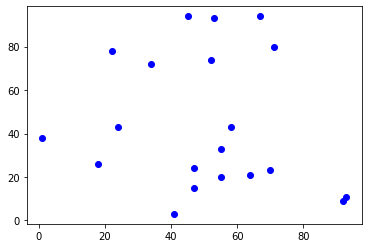

In [8]:
import random
n      = 20
todos  = range(n)
otros  = range(1,n)
random.seed(12345)
points = [(random.randint(0,100),random.randint(0,100)) for i in range(n)]
EPS    = 0.001

import matplotlib.pyplot as plt
def dibuja(selected):                #dibuja una ruta dada como una lista de arcos
    plt.plot([p[0] for p in points], [p[1] for p in points], 'bo')
    for (i,j) in selected:
        plt.plot([points[i][0],points[j][0]], [points[i][1],points[j][1]], 'g-')
    plt.show()

dibuja({})
        
import math
def distance(points, i, j):
    dx = points[i][0] - points[j][0]
    dy = points[i][1] - points[j][1]
    return math.floor(math.sqrt(dx*dx + dy*dy))

dist = {(i,j) : distance(points,i,j) for i in range(n) for j in range(i)}

Resolvamos el TSP simétrico mediante un algoritmo iterativo que elimina un subciclo en cada iteración mirando la solución entera:

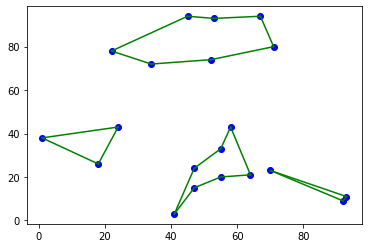

 subtour:  {2, 4, 5, 6, 14, 18, 19}
 subtour:  {0, 3, 7, 8, 10, 12, 13}
 subtour:  {16, 9, 11}
 subtour:  {1, 17, 15}


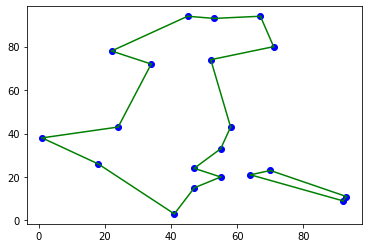

 subtour:  {0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 12, 13, 15, 17, 18, 19}
 subtour:  {16, 9, 11, 14}


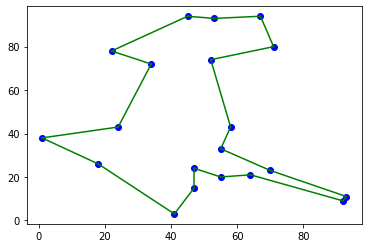

Costo total = 356  in  0.00099945068359375 seconds
Optimal path: [(4, 2), (5, 2), (8, 3), (9, 6), (10, 0), (10, 8), (11, 9), (12, 0), (12, 7), (13, 7), (14, 4), (15, 1), (16, 11), (16, 14), (17, 1), (17, 3), (18, 5), (18, 15), (19, 6), (19, 13)]


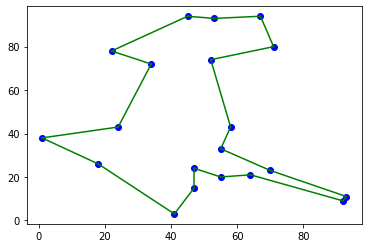

In [10]:
modelo = Model()
modelo.Params.OutputFlag = 0
x = modelo.addVars(dist.keys(), obj=dist, vtype=GRB.BINARY, name='e')

def SEC():
    
    vals = modelo.getAttr('x', x)
    selected = [ (i,j) for i,j in vals.keys() if vals[i,j] > EPS ]
    dibuja(selected)
    
    G = networkx.Graph()
    G.add_edges_from( (i,j) for i,j in vals.keys() if vals[i,j]>EPS )
    Components = list(networkx.connected_components(G))
    if len(Components) == 1:
        return False
    for S in Components:
        print(" subtour: ",S)
        modelo.addConstr( quicksum( x[i,j] for i in S for j in S if j<i ) <= len(S)-1 )
    return True

def TSP1():
    modelo.addConstrs( x.sum(i,'*') + x.sum('*',i) == 2 for i in todos )

    modelo.optimize()
    while SEC():
        modelo.optimize()

    print('Costo total = %g' % modelo.objVal , " in ",modelo.Runtime, "seconds")
    vals = modelo.getAttr('x', x)
    selected = [(i,j) for i,j in vals.keys() if vals[i,j] > EPS]
    print('Optimal path: %s' % str(selected))
    dibuja(selected)
    
TSP1()

Podemos hacer algo incluso mejor: resolvemos primero el nodo raiz asegurándonos de eliminar los primeros subciclos, y luego continuar igual pero con las soluciones enteras:
    

Costo total = 356  in  0.00099945068359375 seconds
Optimal path: [(4, 2), (5, 2), (8, 3), (9, 6), (10, 0), (10, 8), (11, 9), (12, 0), (12, 7), (13, 7), (14, 4), (15, 1), (16, 11), (16, 14), (17, 1), (17, 3), (18, 5), (18, 15), (19, 6), (19, 13)]


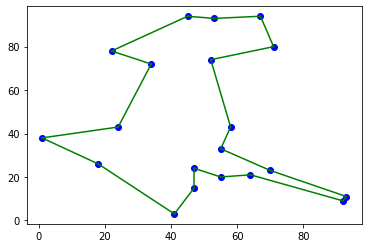

In [14]:
modelo = Model()
modelo.Params.OutputFlag = 0
x = modelo.addVars(dist.keys(), lb=0.0, ub=1.0, obj=dist, vtype=GRB.CONTINUOUS, name='e')

def SEC1():
    vals = modelo.getAttr('x', x)
    G = networkx.Graph()
    G.add_edges_from( (i,j) for i,j in vals.keys() if vals[i,j]>EPS)
    Components = list(networkx.connected_components(G))
    if len(Components) == 1:
        return False
    for S in Components:
        modelo.addConstr( quicksum( x[i,j] for i in S for j in S if j<i) <= len(S)-1 )
    return True
    
def SEC2():
    vals = modelo.getAttr('x', x)
    G = networkx.Graph()
    for i,j in vals.keys():
        if vals[i,j]>EPS:
            G.add_edge( i, j, capacity = vals[i,j] )
           
    corte = False
    free = [True]*n
    for i in otros :
        if free[i]:
            cut_value, partition = networkx.minimum_cut(G, 0, i)
            if cut_value < 2-EPS:
                non_S, S = partition
                modelo.addConstr( quicksum( x[i,j] for i in S for j in S if j<i) <= len(S)-1 ) 
                corte = True
                for j in S: free[j] = False
    return corte

def TSP2():
    modelo.addConstrs( x.sum(i,'*') + x.sum('*',i) == 2 for i in todos )

    modelo.optimize()
    while SEC2():
        modelo.optimize()
        
    for v in modelo.getVars(): v.vtype = GRB.BINARY     # antes problemas continuos ; después problemas enteros
    
    modelo.optimize()
    while SEC1():
        modelo.optimize()

    print('Costo total = %g' % modelo.objVal , " in ",modelo.Runtime, "seconds")
    vals = modelo.getAttr('x', x)
    selected = [(i,j) for i,j in vals.keys() if vals[i,j] > EPS]
    print('Optimal path: %s' % str(selected))
    dibuja(selected)
    
TSP2()

Resolvamos ahora el mismo TSP simétrico pero insertando cortes sobre todas las soluciones enteras que va encontrando también durante el proceso. Para esto necesitamos utilizar las llamadas funciones "callback":

Costo total = 356  in  0.002994537353515625 seconds
Optimal path: [(4, 2), (5, 2), (8, 3), (9, 6), (10, 0), (10, 8), (11, 9), (12, 0), (12, 7), (13, 7), (14, 4), (15, 1), (16, 11), (16, 14), (17, 1), (17, 3), (18, 5), (18, 15), (19, 6), (19, 13)]


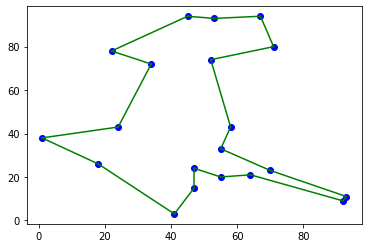

In [16]:
modelo = Model()
modelo.Params.OutputFlag = 0
modelo.Params.lazyConstraints = 1
x = modelo.addVars(dist.keys(), obj=dist, vtype=GRB.BINARY, name='e')

def cbSEC1(modelo, where):
    if where == GRB.Callback.MIPSOL:
        vals = modelo.cbGetSolution(x)           
        G = networkx.Graph()
        G.add_edges_from( (i,j) for i,j in vals.keys() if vals[i,j]>EPS )
        Components = list(networkx.connected_components(G))
        if len(Components) == 1:
            return False
        for S in Components:
            modelo.cbLazy( quicksum( x[i,j] for i in S for j in S if j<i) <= len(S)-1 )
    return True

def TSP3():
    modelo.addConstrs( x.sum(i,'*') + x.sum('*',i) == 2 for i in todos )

    modelo.optimize(cbSEC1)

    print('Costo total = %g' % modelo.objVal , " in ",modelo.Runtime, "seconds")
    vals = modelo.getAttr('x', x)
    selected = [(i,j) for i,j in vals.keys() if vals[i,j] > EPS]
    print('Optimal path: %s' % str(selected))
    dibuja(selected)
    
TSP3()

Por último, resolvamos el mismo problema pero evaluando el corte también sobre cada solución fraccionaria, lo que requiere calcular un "min-cut problem":

Costo total = 356  in  0.0050029754638671875 seconds
Optimal path: [(4, 2), (5, 2), (8, 3), (9, 6), (10, 0), (10, 8), (11, 9), (12, 0), (12, 7), (13, 7), (14, 4), (15, 1), (16, 11), (16, 14), (17, 1), (17, 3), (18, 5), (18, 15), (19, 6), (19, 13)]


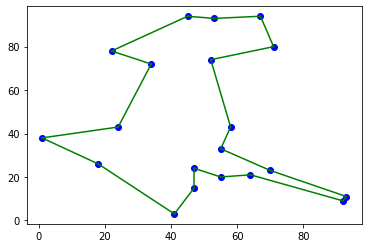

In [17]:
modelo = Model()
modelo.Params.OutputFlag = 0
modelo.Params.lazyConstraints = 1
x = modelo.addVars(dist.keys(), obj=dist, vtype=GRB.BINARY, name='e')

def cbSEC2(modelo, where):
    corte = False
    if where == GRB.Callback.MIPSOL:
        vals = modelo.cbGetSolution(x)     # verificar UB solutions      
        G = networkx.Graph()
        G.add_edges_from( (i,j) for i,j in vals.keys() if vals[i,j]>EPS )
        Components = list(networkx.connected_components(G))
        if len(Components) == 1:
            return False
        for S in Components:
            modelo.cbLazy( quicksum( x[i,j] for i in S for j in S if j<i) <= len(S)-1 )
            corte = True
        
    if where == GRB.Callback.MIPNODE:
        vals = modelo.cbGetNodeRel(x)      # verificar LB solutions
        G = networkx.Graph()
        for i,j in vals.keys():
            if vals[i,j]>EPS:
                G.add_edge( i, j, capacity = vals[i,j] )
            
        free = [True]*n
        for i in otros :
            if free[i]:
                cut_value, partition = networkx.minimum_cut(G, 0, i)
                if cut_value < 2-EPS:
                    non_S, S = partition
                    modelo.cbLazy( quicksum( x[i,j] for i in S for j in S if j<i) <= len(S)-1 ) 
                    corte = True
                    for j in S: free[j] = False
    return corte

def TSP4():
    modelo.addConstrs( x.sum(i,'*') + x.sum('*',i) == 2 for i in todos )

    modelo.optimize(cbSEC2)

    print('Costo total = %g' % modelo.objVal , " in ",modelo.Runtime, "seconds")
    vals = modelo.getAttr('x', x)
    selected = [(i,j) for i,j in vals.keys() if vals[i,j] > 0.5]
    print('Optimal path: %s' % str(selected))
    dibuja(selected)

TSP4()

Veamos ahora otras variantes del TSP.

# TSP con ventanas temporales

In [29]:
from ortools.linear_solver import pywraplp
import random as rand

solver = pywraplp.Solver('TSP Time Windows', pywraplp.Solver.CBC_MIXED_INTEGER_PROGRAMMING)

# x and y are integer non-negative variables.
nodes = 5
rand.seed(12345)
cost = { (i,j): rand.randint(1,10) for i in range(nodes) for j in range(nodes) if i!=j}
e = [1400, 900, 1200, 800, 700]
l = [1400, 1100, 1300, 1000, 900]
t = {(i,j): 100 for i in range(nodes) for j in range(nodes) if i!=j}
s ={i: 100 for i in range(nodes)}

print("cost:",cost)
print("t:",t)
print("s:",s)
x = {}
for i in range(nodes):
    for j in range(nodes):
        if i!=j:
            x[i, j] = solver.BoolVar('x[%i, %i]' % (i, j))

u = {}
for i in range(1,nodes):
    u[i] = solver.IntVar(1.0,solver.infinity(),'u[%i]' % (i))

solver.Minimize(solver.Sum([cost[i,j]*x[i,j] for i in range(nodes) for j in range(nodes) if i!=j]))

for i in range(nodes):
    solver.Add(solver.Sum([x[i,j] for j in range(nodes) if i!=j]) == 1)

for j in range(nodes):
    solver.Add(solver.Sum([x[i,j] for i in range(nodes) if i!=j]) == 1)

for i in range(1,nodes):
    solver.Add(e[i]<=u[i]<=l[i])

for i in range(1,nodes):
    for j in range(1,nodes):
        if i!=j:
            solver.Add(u[j]>=u[i]+(s[i]+t[i,j])*x[i,j]-(l[i]-e[j])*(1-x[i,j]))

sol = solver.Solve()
if sol == solver.OPTIMAL:
    print('Wall time = ' + str(solver.WallTime()) + ' ms')
    print('Número de variables =', solver.NumVariables())
    print('Número de restricciones =', solver.NumConstraints())
    print('Costo total =', solver.Objective().Value())
    recorrido = '0'
    i=0
    while i != -1:
        for j in range(nodes):
            if i!=j:
                if x[i, j].solution_value() > 0:
                    recorrido += ' -c(' + str(cost[i,j]) +')-> ' + str(j)
                    aux = j
        if aux != 0:
            i = aux
        else:
            i = -1
    print(recorrido)

cost: {(0, 1): 7, (0, 2): 1, (0, 3): 5, (0, 4): 6, (1, 0): 4, (1, 2): 5, (1, 3): 10, (1, 4): 7, (2, 0): 3, (2, 1): 6, (2, 3): 2, (2, 4): 7, (3, 0): 5, (3, 1): 9, (3, 2): 3, (3, 4): 10, (4, 0): 9, (4, 1): 3, (4, 2): 6, (4, 3): 2}
t: {(0, 1): 100, (0, 2): 100, (0, 3): 100, (0, 4): 100, (1, 0): 100, (1, 2): 100, (1, 3): 100, (1, 4): 100, (2, 0): 100, (2, 1): 100, (2, 3): 100, (2, 4): 100, (3, 0): 100, (3, 1): 100, (3, 2): 100, (3, 4): 100, (4, 0): 100, (4, 1): 100, (4, 2): 100, (4, 3): 100}
s: {0: 100, 1: 100, 2: 100, 3: 100, 4: 100}
Wall time = 26 ms
Número de variables = 24
Número de restricciones = 26
Costo total = 25.0
0 -c(6)-> 4 -c(2)-> 3 -c(9)-> 1 -c(5)-> 2 -c(3)-> 0


# TSP con relaciones de precedencia

In [ ]:
from ortools.linear_solver import pywraplp
import random as rand

solver = pywraplp.Solver('Precedencias', pywraplp.Solver.CBC_MIXED_INTEGER_PROGRAMMING)

# x and y are integer non-negative variables.
nodes = 10
rand.seed(12345)
cost = { (i,j): rand.randint(10,100) for i in range(nodes) for j in range(nodes) if i!=j}
x = {}
for i in range(nodes):
    for j in range(nodes):
        if i!=j:
            x[i, j] = solver.BoolVar('x[%i, %i]' % (i, j))
v = {}
for i in range(1, nodes):
    for j in range(1, nodes):
        if i != j:
            v[i, j] = solver.BoolVar('v[%i, %i]' % (i, j))

# Aqui se almacenarán las precedencias que se deseen
precedencias = [[3,2],[1,2]]

solver.Minimize(solver.Sum([cost[i,j]*x[i,j] for i in range(nodes) for j in range(nodes) if i!=j]))

for i in range(nodes):
    solver.Add(solver.Sum([x[i,j] for j in range(nodes) if i!=j]) == 1)

for j in range(nodes):
    solver.Add(solver.Sum([x[i,j] for i in range(nodes) if i!=j]) == 1)

for i in range(1,nodes):
    for j in range(1,nodes):
        if i != j:
            solver.Add((v[i,j]+v[j,i]) == 1)

for i in range(1,nodes):
    for j in range(1,nodes):
        if i != j:
            for k in range(1, nodes):
                if (k != i) & (k != j):
                    solver.Add( v[i,j]+v[j,k] <= v[i,k]+1 )

for i in range(1,nodes):
    for j in range(1,nodes):
        if i != j:
            solver.Add(x[i,j] <= v[i,j])

for p in precedencias:
    solver.Add(v[p[0],p[1]] == 1)

sol = solver.Solve()
if sol == solver.OPTIMAL:
    print('Wall time = ' + str(solver.WallTime()) + ' ms')
    print('Número de variables =', solver.NumVariables())
    print('Número de restricciones =', solver.NumConstraints())
    print('Costo total =', solver.Objective().Value())
    recorrido = '0'
    i=0
    while i != -1:
        for j in range(nodes):
            if i!=j:
                if x[i, j].solution_value() > 0:
                    recorrido += ' -c(' + str(cost[i,j]) +')-> ' + str(j)
                    aux = j
        if aux != 0:
            i = aux
        else:
            i = -1
    print(recorrido)    

# TSP con recogidas y entregas de una mercancía

In [ ]:
from ortools.linear_solver import pywraplp
import random as rand

solver = pywraplp.Solver('TSPrecogidasYEntregas1Mercancia', pywraplp.Solver.CBC_MIXED_INTEGER_PROGRAMMING)

nodes = 10
cost = { (i,j): rand.randint(10,100) for i in range(nodes) for j in range(nodes) if i!=j}
rand.seed(42)

# Demandas
aux = 0
d = []
for i in range(1,nodes):
    x = rand.randint(-10,10)
    d.append(x)
    aux+=x
d.append(-aux)
# NOTA
# Al hacerlo aleatorio, para saber la demanda del primer nodo se está
# haciendo una suma de la demanda de todos los nodos y luego poniéndose
# la inversa de este número como la demanda del almacén.
# Por esto hay que controlar manualmente la Q (carga máxima del camión),
# pues esta ha de ser mayor que las demandas y la demanda del almacen
# puede ser muy alta por lo previamente explicado.
# Carga máxima del camión
Q = 26

print("Demandas:",d)
print("Q:",Q)

x = { (i,j): solver.BoolVar('x[%i, %i]' % (i, j)) for i in range(nodes) for j in range(nodes) if i!=j}
f = {}
for i in range(nodes):
    for j in range(nodes):
        if i!=j:
            f[i, j] = solver.IntVar(0.0,solver.infinity(),'f[%i, %i]' % (i, j))
u = {}
for i in range(1,nodes):
    u[i] = solver.IntVar(1.0,solver.infinity(),'u[%i]' % (i))

solver.Minimize(solver.Sum([cost[i,j]*x[i,j] for i in range(nodes) for j in range(nodes) if i!=j]))

for i in range(nodes):
    solver.Add(solver.Sum([x[i,j] for j in range(nodes) if i!=j]) == 1)

for j in range(nodes):
    solver.Add(solver.Sum([x[i,j] for i in range(nodes) if i!=j]) == 1)

for i in range(1,nodes):
    for j in range(1,nodes):
        if i!=j:
            solver.Add(u[j]>=(u[i]+x[i,j]-(nodes-2)*(1-x[i,j])+(nodes-3)*x[j,i]))

for i in range(nodes):
    solver.Add((solver.Sum([f[j,i] for j in range(nodes) if i!=j])-solver.Sum([f[i,j] for j in range(nodes) if i!=j])) == d[i])
for i in range(nodes):
    for j in range(nodes):
        if i!=j:
            solver.Add(0<=f[i,j]<=Q*x[i,j])

sol = solver.Solve()
if sol == solver.OPTIMAL:
    print('Wall time = ' + str(solver.WallTime()) + ' ms')
    print('Número de variables =', solver.NumVariables())
    print('Número de restricciones =', solver.NumConstraints())
    print('Costo total =', solver.Objective().Value())
    recorrido = '0'
    i=0
    while i != -1:
        for j in range(nodes):
            if i!=j:
                if x[i, j].solution_value() > 0:
                    """ recorrido += ' -c(' + str(cost[i][j]) +')-> ' + str(j) """
                    recorrido += ' --f(' + str(f[i,j].solution_value()) +'),c(' + str(cost[i,j]) +')--> ' + str(j)
                    aux = j
        if aux != 0:
            i = aux
        else:
            i = -1
    print(recorrido)

# TSP con varias pilas

Asumamos ahora una empresa que se dedica a recoger pallets desde $n$ lugares de Tenerife para entregarlos luego en otros $n$ lugares en Gran Canaria. Concretamente, pensemos en un camión que arrastra un contenedor inicialmente vacío. Cada cliente en Tenerife entrega al camión 1 pallet, que entre en el contenedor por detrás situándose en una de las $m$ pilas del contenedor. No se pueden reorganizar los pallets ni al recogerlos ni al entregarlos. Sólo se pueden apilar por detras los pallets, y recoger por detrás los pallets. En Tenerife el camión debe hacer una ruta para ir recogiéndolo, y en Gran Ganaria otra ruta para ir entregando. El contenedor permite hasta $m \times q$ pallets, siendo $m$ el número de pilas (columnas) y $q$ la cantidad máxima de pallets por pila (filas), asumiendo $n\leq m \times q$. Se buscan las dos rutas de coste total mínimo. Observemos que el caso $m=1$ equivale a resolver un TSP, mientras que cuando $m>1$ la situación se complica:

In [ ]:
from ortools.linear_solver import pywraplp
import random as rand

solver = pywraplp.Solver('TSP2', pywraplp.Solver.CBC_MIXED_INTEGER_PROGRAMMING)

# x and y are integer non-negative variables.
nodes = 10
pilas = 3
q = 5
rand.seed(42)
cost_t = { (i,j): rand.randint(10,100) for i in range(nodes) for j in range(nodes) if i!=j}
cost_g = { (i,j): rand.randint(10,100) for i in range(nodes) for j in range(nodes) if i!=j}

x_t = { (i,j): solver.BoolVar('x_t[%i, %i]' % (i, j)) for i in range(nodes) for j in range(nodes) if i!=j}
x_g = { (i,j): solver.BoolVar('x_g[%i, %i]' % (i, j)) for i in range(nodes) for j in range(nodes) if i!=j}

v_t = { (i,j): solver.BoolVar('v_t[%i, %i]' % (i, j)) for i in range(1,nodes) for j in range(1,nodes) if i!=j}
v_g = { (i,j): solver.BoolVar('v_g[%i, %i]' % (i, j)) for i in range(1,nodes) for j in range(1,nodes) if i!=j}

z = { (i,k): solver.BoolVar('z[%i, %i]' % (i, k)) for i in range(1,nodes) for k in range(pilas)}

solver.Minimize(solver.Sum([cost_t[i,j]*x_t[i,j] for i in range(nodes) for j in range(nodes) if i!=j])+solver.Sum([cost_g[i,j]*x_g[i,j] for i in range(nodes) for j in range(nodes) if i!=j]))

for i in range(nodes):
    solver.Add(solver.Sum([x_t[i,j] for j in range(nodes) if i!=j]) == 1)

for j in range(nodes):
    solver.Add(solver.Sum([x_t[i,j] for i in range(nodes) if i!=j]) == 1)

for i in range(nodes):
    solver.Add(solver.Sum([x_g[i,j] for j in range(nodes) if i!=j]) == 1)

for j in range(nodes):
    solver.Add(solver.Sum([x_g[i,j] for i in range(nodes) if i!=j]) == 1)

for i in range(1,nodes):
    for j in range(1,nodes):
        if i != j:
            solver.Add((v_t[i,j]+v_t[j,i]) == 1)
            solver.Add((v_g[i,j]+v_g[j,i]) == 1)

for i in range(1,nodes):
    for j in range(1,nodes):
        if i != j:
            for k in range(1, nodes):
                if (k != i) & (k != j):
                    solver.Add( v_t[i,j]+v_t[j,k] <= v_t[i,k]+1 )
                    solver.Add( v_g[i,j]+v_g[j,k] <= v_g[i,k]+1 )

for i in range(1,nodes):
    for j in range(1,nodes):
        if i != j:
            solver.Add(x_t[i,j] <= v_t[i,j])
            solver.Add(x_g[i,j] <= v_g[i,j])

for i in range(1,nodes):
    for k in range(pilas):
        solver.Add(z[i,k] == 1)
        solver.Add(z[i,k] <= q)

for i in range(1,nodes):
    for j in range(1,nodes):
        if i!=j:
            for k in range(pilas):
                solver.Add(v_t[i,j]+v_g[i,j]+z[i,k]+z[j,k] <= 3)

sol = solver.Solve()
if sol == solver.OPTIMAL:
    print('Wall time = ' + str(solver.WallTime()) + ' ms')
    print('Número de variables =', solver.NumVariables())
    print('Número de restricciones =', solver.NumConstraints())
    print('Costo total =', solver.Objective().Value())
    recorrido = '0'
    i=0
    while i != -1:
        for j in range(nodes):
            if i!=j:
                if x_t[i, j].solution_value() > 0:
                    recorrido += ' -c(' + str(cost_t[i,j]) +')-> ' + str(j)
                    aux = j
        if aux != 0:
            i = aux
        else:
            i = -1
    print("T ::: " + recorrido)
    recorrido = '0'
    i=0
    while i != -1:
        for j in range(nodes):
            if i!=j:
                if x_g[i, j].solution_value() > 0:
                    recorrido += ' -c(' + str(cost_g[i,j]) +')-> ' + str(j)
                    aux = j
        if aux != 0:
            i = aux
        else:
            i = -1
    print("G ::: " + recorrido)

# TSP con visitas consistentes

In [ ]:
m = 4   # number of days
n = 50  # number of locations
ñ = 45  # number of customers in each day
L = 50  # maximum difference for consistency
EPS = 0.001

days      = range(m)
locations = range(n)
customers = range(1,n)

import random
random.seed(12345)
points = [(random.randint(0,100),random.randint(0,100)) for i in range(n)]

V = {}
D = {}
for i in customers: D[i] = []
for d in days:
    V[d] = random.sample(customers,ñ)
    for i in V[d]: D[i].append(d)
    V[d].append(0)
     
import math
def distance(points, i, j):
    dx = points[i][0] - points[j][0]
    dy = points[i][1] - points[j][1]
    return math.floor(math.sqrt(dx*dx + dy*dy))

dist = {(i,j) : distance(points,i,j) for i in locations for j in locations if i!=j}

import matplotlib.pyplot as plt
def dibuja(selected):                #dibuja una ruta dada como una lista de arcos
    plt.plot([p[0] for p in points], [p[1] for p in points], 'bo')
    plt.plot( points[0][0] , points[0][1] , 'rs')
    for (i,j) in selected:
        plt.plot([points[i][0],points[j][0]], [points[i][1],points[j][1]], 'g-')
    plt.show()
        
dibuja({})
from gurobipy import *

modelo = Model()
x = tupledict()
for d in days:
    for i in V[d]:
        for j in V[d]:
            if i!=j :
                x[i,j,d] = modelo.addVar(obj=dist[i,j], vtype=GRB.BINARY, name='a[%d,%d,%d]'%(i,j,d))
f = tupledict()

import networkx as nx
                
def SEC():
    print("miramos subtours")
    corte = False
    vals = modelo.getAttr('x', x)
    for d in days:
        G = nx.Graph()
        G.add_edges_from( (i,j) for i in V[d] for j in V[d] if i!=j and vals[i,j,d]>EPS )
        Components = list(nx.connected_components(G))
        if len(Components) > 1:
            for S in Components:
                modelo.addConstr( quicksum( x[i,j,d] for i in S for j in S if i!=j ) <= len(S)-1 )
                corte = True
    return corte  


def Consistency():
    print( "miramos consistencia")
    vals = modelo.getAttr('x', x)
    length = {}
    for d in days:
        G = nx.DiGraph()
        G.add_weighted_edges_from( (i,j,dist[i,j]) for i in V[d] for j in V[d] if i!=j and vals[i,j,d]>EPS )
        for i in V[d]:
            length[i,d] = nx.dijkstra_path_length(G,source=0,target=i)
        G.clear()
    maximo = 0
    for i in customers:
        for p in D[i]:
            for q in D[i]:
                if p<q and maximo < abs(length[i,p]-length[i,q])  :
                    maximo = abs(length[i,p]-length[i,q])
                    kk = i
                    pp = p
                    qq = q
    print( "maximo=",maximo , "kk=",kk,"pp=",pp,"qq=",qq, "lengthpp=",length[kk,pp],"lengthqq=",length[kk,qq])
    if maximo <= L :
        return False

      
    for i in V[pp]:
        for j in V[pp]:
            if i!=j:
                f[i,j,kk,pp] = modelo.addVar(obj=0, vtype=GRB.BINARY, name='f[%d,%d,%d,%d]'%(i,j,kk,pp))
    for i in V[qq]:
        for j in V[qq]:
            if i!=j:
                f[i,j,kk,qq] = modelo.addVar(obj=0, vtype=GRB.BINARY, name='f[%d,%d,%d,%d]'%(i,j,kk,qq))
        
    modelo.addConstr(sum(f[0,j,kk,pp] for j in V[pp] if j!=0 ) == 1)
    modelo.addConstr(sum(f[j,0,kk,pp] for j in V[pp] if j!=0 ) == 0)
    modelo.addConstrs(sum(f[j,i,kk,pp]-f[i,j,kk,pp] for j in V[pp] if j!=i) == 0 for i in V[pp] if i!=kk and i!=0 )
    modelo.addConstrs( f[i,j,kk,pp] <= x[i,j,pp] for i in V[pp] for j in V[pp] if i!=j )

    modelo.addConstr(sum(f[0,j,kk,qq] for j in V[qq] if j!=0 ) == 1)
    modelo.addConstr(sum(f[j,0,kk,qq] for j in V[qq] if j!=0 ) == 0)
    modelo.addConstrs(sum(f[j,i,kk,qq]-f[i,j,kk,qq] for j in V[qq] if j!=i) == 0 for i in V[qq] if i!=kk and i!=0 )
    modelo.addConstrs( f[i,j,kk,qq] <= x[i,j,qq] for i in V[qq] for j in V[qq] if i!=j )
     
    modelo.addConstr( sum(dist[i,j]*f[i,j,kk,pp] for i in V[pp] for j in V[pp] if i!=j ) - sum(dist[i,j]*f[i,j,kk,qq] for i in V[qq] for j in V[qq] if i!=j ) <= L)
    modelo.addConstr( sum(dist[i,j]*f[i,j,kk,pp] for i in V[pp] for j in V[pp] if i!=j ) - sum(dist[i,j]*f[i,j,kk,qq] for i in V[qq] for j in V[qq] if i!=j ) >= -L)

    return True


def CATSPsec():
    modelo.addConstrs(sum(x[i,j,k] for j in V[k] if j!=i) == 1 for k in days for i in V[k] )
    modelo.addConstrs(sum(x[j,i,k] for j in V[k] if j!=i) == 1 for k in days for i in V[k] )

    modelo.Params.OutputFlag = 0

    modelo.optimize()
    while SEC() or Consistency():
        modelo.optimize()    
        if modelo.status != GRB.Status.OPTIMAL:
            print(' No solution ; status=',modelo.status)
            return

    print('Costo total = %g' % modelo.objVal)
    print('Time = ',modelo.Runtime, "seconds")
    vals = modelo.getAttr('x', x)
    selected = [(i,j,k) for i,j,k in vals.keys() if vals[i,j,k] > EPS]
    print('Optimal path: %s' % str(selected))
    for k in days: 
        plt.subplot(2, 2, k+1)
        selected = [ (i,j) for i in V[k] for j in V[k] if i!=j and vals[i,j,k]>EPS]
        dibuja(selected)
        
CATSPsec()